We’ll attempt to predict the **median price** of homes in a given Boston
suburb in the mid-1970s, given data points about the suburb at the time, such as the
crime rate, the local property tax rate, and so on.

- dataset has relatively few data points
- each feature has a diff scale

In [2]:
# importing data
import tensorflow

2023-03-13 18:29:27.820310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_labels), (test_data, test_labels) = (boston_housing.load_data())

57026/57026 [==============================] - 0s 2us/step


In [5]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [8]:
train_labels[:10]
# targets are median value of owner-occupied homes, in thousands of dollars

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

### Preparing data

In [9]:
# normalize data 
# 0 mean and unit standard deviation
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# test data is normalized using values computed from train data
test_data -= mean
test_data /= std

## NOTE: quantities used for normalizing the test data are computed using the training data. You should never use any quantity computed on the test data in your workflow, even for something as simple as data normalization.

### Building model

In [18]:
from tensorflow.keras import layers
from tensorflow import keras

In [12]:
# custom function to build a model
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
# no activation is used for the last layer
# using activation restricts the range of output values

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Model validation

As number of data samples is less, holdout splitting might result in validation scores having a high variance with regard to validation split.

Hence use k-fold cross validation

In [20]:
import numpy as np

# number of partitions
k = 4

# get size of each partition = size of validation data
num_val_samples = len(train_data)//k

# define number of epochs
num_epochs = 100

# list to hold each score
all_scores = []

# k iterations
for i in range(k):
    print(f"Processing fold #{i}")
    
    # get validation split
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_labels[i*num_val_samples : (i+1)*num_val_samples]
    
    # getting train split
    partial_train_data = np.concatenate([
        train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]
    ], axis=0)
    
    partial_train_targets = np.concatenate([
        train_labels[:i*num_val_samples],
        train_labels[(i+1)*num_val_samples:]
    ], axis=0)
    
    # build model using custom function
    model = build_model()
    
    # fitting model
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs,
             batch_size = 16, verbose=0)
    
    # evaluating model
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [21]:
all_scores

[1.96974515914917, 2.3963546752929688, 2.514951705932617, 2.307213544845581]

In [22]:
np.mean(all_scores)

2.2970662713050842

### Training a model for 500 epochs

In [25]:
# train for 500 epochs now
num_epochs = 500

# list of mae histories for each cross validation model
all_mae_histories = []

# k iterations (cross validations)
for i in range(k):
    print(f"Processing fold #{i}")
    
    # splitting data
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_labels[:i * num_val_samples],
        train_labels[(i + 1) * num_val_samples:]],
        axis=0)
    
    # building model
    model = build_model()
    
    # fitting model with history
    history = model.fit(partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=16, verbose=0)
    
    # obtaining validation mae history
    mae_history = history.history["val_mae"]
    
    # appending to all histories
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [30]:
len(all_mae_histories[0])

500

In [31]:
# get average per epoch mae for all folds
# epoch 1 mae = mean of all epoch 1 mae

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [34]:
len(average_mae_history)

500

In [37]:
import matplotlib.pyplot as plt

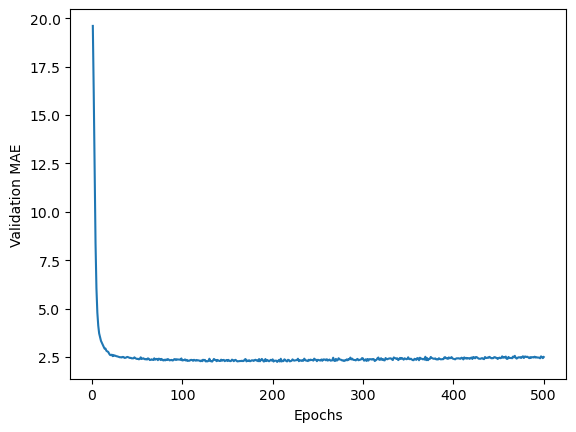

In [38]:
# plotting avg mae history
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show();

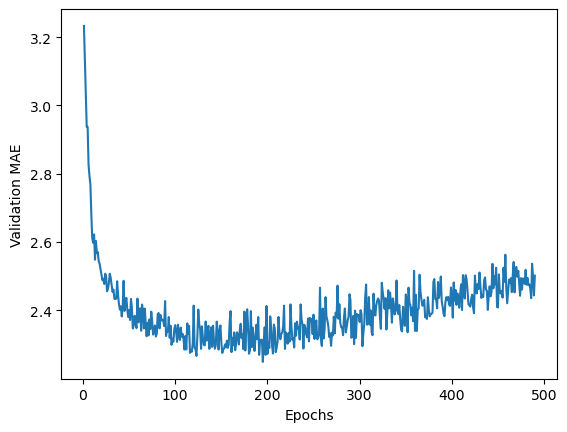

In [39]:
# scale plot to see it better
trun_mae_history = average_mae_history[10:]
plt.plot(range(1, len(trun_mae_history)+1), trun_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show();

Validation MAE stops improving after 120-140 epochs

### Training final model

In [42]:
model = build_model()
model.fit(train_data, train_labels, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 23ms/step - loss: 13.3428 - mae: 2.4371


In [43]:
test_mae_score

2.437062978744507